In [8]:
# Обработка данных
import numpy as np
import pandas as pd

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# ml-algorithms
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# MNIST dataset
from sklearn.datasets import load_digits
digits_df = load_digits()
digits_features = digits_df['data']
digits_labels = digits_df['target']

# Модуль с ф-циями, которые я написал для удобства
from extra_modules import tools

In [12]:
from importlib import reload
reload(tools)

<module 'extra_modules.tools' from '/home/vsevolod/Documents/python_stuff/mnist-generation-experiments/extra_modules/tools.py'>

Посмотрим за что отвечают компоненты в PCA, натренированные только на 0

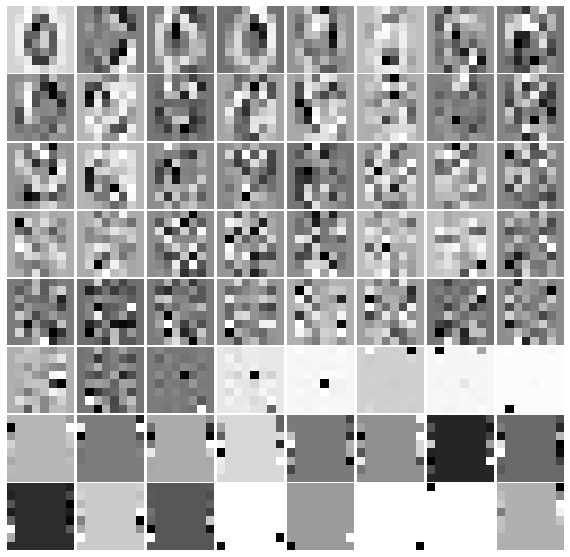

In [16]:
X_zeros = digits_features[digits_labels == 0]
pca = PCA(n_components=64)
pca.fit(X_zeros)
tools.display_rows_as_images(pca.components_);

А теперь на всех данных

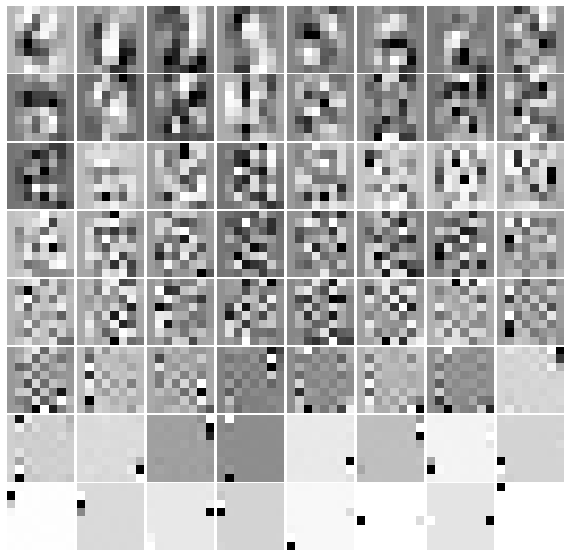

In [19]:
pca = PCA(n_components=64)
pca.fit(digits_features)
tools.display_rows_as_images(pca.components_);